In [1]:
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline

def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
reset_graph()
np.random.seed(42)
n_hidden1 = 100
n_hidden2 = 2
n_inputs = 1000
n_outputs = 3
train_split = .8
batch_size = 10
n_epochs = 1001

In [3]:
def duffing_drift(x):
    alpha = -1.0
    beta = 1.0
    delta = 0.3
    gamma = 0.2
    omega = 1.0
    out = np.zeros(x.shape)

    # f_1(x_1,x_2,x_3) = x_2
    out[:, 0] = x[:, 1]

    # f_2(x_1,x_2,x_3) = -delta*x_2 - alpha*x_1 - beta*x_1^3 + gamma*cos(omega*x_3)
    out[:, 1] = -delta*x[:, 1] - alpha*x[:, 0] - beta*np.power(x[:, 0],3) + gamma*np.cos(omega*x[:, 2])

    # f_3(x_1,x_2,x_3) = 1
    out[:, 2] = 1.0

    return out

In [4]:
# true diffusion matrix
def trueg():
    out = np.zeros((3,3))
    out[0,0] = 0.4
    out[0,1] = 0.0 # 0.125
    out[1,0] = 0.0 # 0.125
    out[1,1] = 0.25
    out[2,2] = 0.0
    return out

In [5]:
def function_to_learn(x):
    return duffing_drift(x)

def function_to_learn_with_noise(x):
    return duffing_drift(x) + 0.125 * np.float32(np.random.randn(*x.shape))

In [6]:
X_all = np.float32(np.random.uniform(-1, 1, (3, n_inputs))).T
np.random.shuffle(X_all)
train_size = int(n_inputs * train_split)
X_train = X_all[:train_size, :]
X_validation = X_all[train_size:, :]
y_train = function_to_learn_with_noise(X_train)
y_validation = function_to_learn_with_noise(X_validation)

In [7]:
print(X_train)
print(y_train)

[[ 0.18826143 -0.87946522  0.38506487]
 [-0.09891173 -0.63712329  0.50685585]
 [-0.33300164  0.23002593  0.26872739]
 ..., 
 [-0.60841775 -0.64063376 -0.3136653 ]
 [ 0.36846605 -0.86928731 -0.54936612]
 [ 0.73101425  0.38990217  0.0317238 ]]
[[-0.83804752  0.69745848  0.87966412]
 [-0.75974669  0.39195532  1.12979721]
 [ 0.09398599 -0.33218227  0.98642588]
 ..., 
 [-0.57035248  0.09479329  0.87744131]
 [-0.83378024  0.78199463  0.89731439]
 [ 0.36867471  0.23574378  0.95666131]]


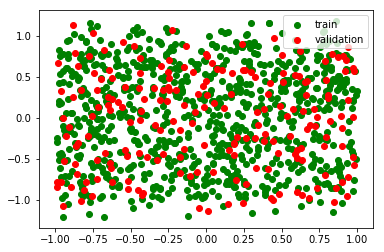

In [8]:
plt.figure(1) 
plt.scatter(X_train[:, 0], y_train[:, 0], c = 'green', label = 'train') 
plt.scatter(X_validation[:, 0], y_validation[:, 0], c = 'red', label = 'validation') 
plt.legend()

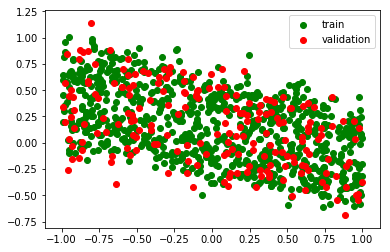

In [9]:
plt.figure(1) 
plt.scatter(X_train[:, 1], y_train[:, 1], c = 'green', label = 'train') 
plt.scatter(X_validation[:, 1], y_validation[:, 1], c = 'red', label = 'validation') 
plt.legend()

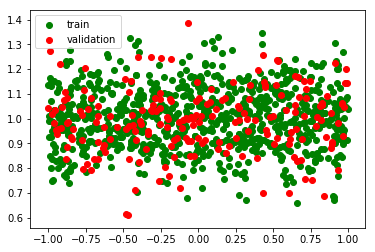

In [10]:
plt.figure(1) 
plt.scatter(X_train[:, 2], y_train[:, 2], c = 'green', label = 'train') 
plt.scatter(X_validation[:, 2], y_validation[:, 2], c = 'red', label = 'validation') 
plt.legend()

In [11]:
X = tf.placeholder(tf.float32, shape = (None, 3), name = "X")
y = tf.placeholder(tf.float32, shape = (None, 3), name = "y")

In [12]:
with tf.name_scope("function_approximator"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, name = "hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, name = "hidden2")
#     hidden3 = tf.layers.dense(hidden2, n_hidden3, activation = tf.nn.relu, name = "hidden3")
    logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")

In [13]:
with tf.name_scope("loss"):
    loss = tf.nn.l2_loss(logits - y)

In [14]:
learning_rate = 0.01

with tf.name_scope("train"):
#     optimizer = tf.train.FtrlOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
with tf.name_scope("eval"):
    mse = tf.nn.l2_loss(logits - y_validation)

In [18]:
with tf.Session() as sess:
    init.run()
    errors = []
    for epoch in range(n_epochs):
        for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train), batch_size)):
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse_validation = sess.run(mse, feed_dict = {X: X_validation})
        errors.append(mse_validation)
        if epoch % 100 == 0:
            print("Epoch:", epoch, "Validation accuracy:", mse_validation)

    save_path = saver.save(sess, "./3dim_2hiddenLayers.ckpt")

Epoch: 0 Validation accuracy: 22.6852
Epoch: 100 Validation accuracy: 12.2365
Epoch: 200 Validation accuracy: 6.11908
Epoch: 300 Validation accuracy: 6.12525
Epoch: 400 Validation accuracy: 6.15287
Epoch: 500 Validation accuracy: 6.16567
Epoch: 600 Validation accuracy: 6.17923
Epoch: 700 Validation accuracy: 6.16913
Epoch: 800 Validation accuracy: 6.17221
Epoch: 900 Validation accuracy: 6.18584
Epoch: 1000 Validation accuracy: 6.18416


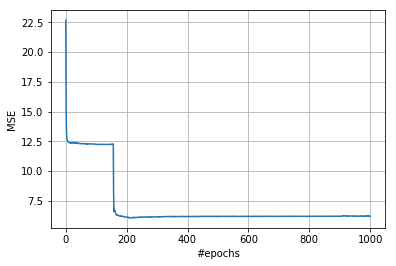

In [19]:
plt.plot(errors)
plt.xlabel('#epochs')
plt.ylabel('MSE')
plt.grid(True)